* ~~NVIDIA architecture is implemented~~
* Images are:
    * ~~cropped~~
    * ~~normalised~~
    * ~~flipped~~
* ~~Correction based on left and right images is added~~
* ~~Counter-clockwise driving is added~~
* Data is augmented with turns
* Data is augmented with recoveries
* Second track is used for data gathering
* More data is collected (3 times - normal, 1-2 times - recoveries, turns, etc)
* Losses are visualised
* ~~`fit_generator` is used for memory savings~~

In [25]:
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import io; io.use_plugin('matplotlib')
import keras
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.regularizers import l2, activity_l2
from skimage.transform import warp, SimilarityTransform
import matplotlib.pyplot as plt
import random

In [58]:
data_paths = ['../images/Run/']#, '../images/turns/']

In [59]:
lines = []
for path in data_paths:
    with open(path + 'driving_log.csv') as f:
        reader = csv.reader(f)
        if path == '../images/RunU/':
            next(reader, None)
        for line in reader:
            lines.append(line)

In [60]:
#
# Dataset statistics:
#

# Size of dataset

print("Number of samples (3 pictures each): {}".format(len(lines)))

Number of samples (3 pictures each): 9482


In [29]:
def balance_data(samples, threshold=900):
    y = []
    for sample in samples:
        angle = float(sample[3])
        y.append(angle)
    binwidth = 0.01
    bins = np.arange(min(y), max(y) + binwidth, binwidth)
    
    plt.figure(figsize=(10,5))
    plt.hist(y, bins)
    plt.grid()
    plt.savefig('report_images/hist.png', bbox_inches='tight')
    plt.show()
    
    hist, b = np.histogram(y, bins)
    H = hist[hist >= threshold] # number of values per bin
    idx = np.where(hist >= threshold)[0] # list of corresponding indices

    elements_to_remove = []
    for i, h in enumerate(H):
        q = list(np.where((b[idx[i]+1] >= y) & (y >= b[idx[i]]))[0])
        elements_to_remove.extend(random.sample(q, k=h-threshold))
        
    result = np.delete(samples, elements_to_remove, axis=0)    
    y_res = []
    for sample in result:
        angle = float(sample[3])
        y_res.append(angle)
    plt.figure(figsize=(15,5))
    plt.hist(y_res, bins)
    plt.grid()
    plt.show()
    return result

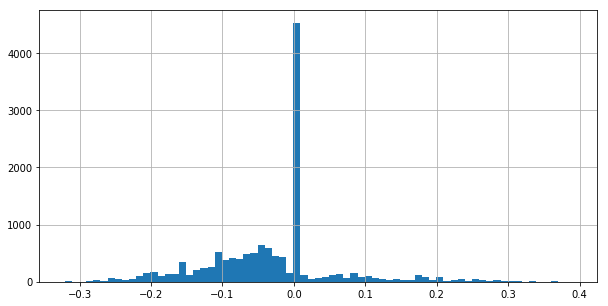

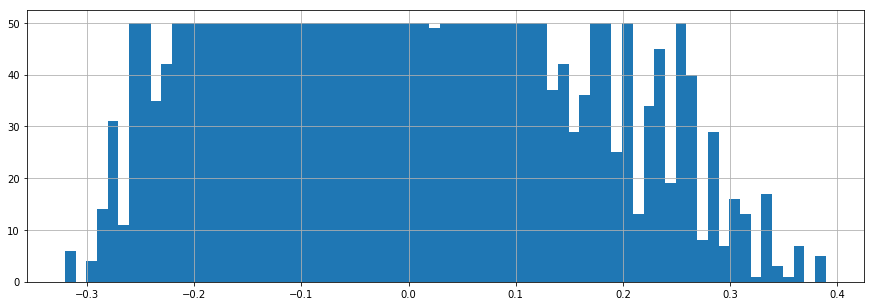

Number of samples after truncation (3 pictures each): 2619


In [30]:
lines_test = balance_data(lines, threshold=50)
print("Number of samples after truncation (3 pictures each): {}".format(len(lines_test)))

In [31]:
def pre_processing(img):
    # crop image - 65 pixels off the top and 27 off the bottom
    new_img = img[65:133,:,:]
    # apply gaussian blur
    new_img = cv2.GaussianBlur(new_img, (3,3), 0)
    # change colormap from BGR(!because opencv opens images in BGR by default) to YUV.
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

In [5]:
# generator with data augmentation
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            measurements = []
            for sample in batch_samples:

            	# find the index of '/image' in the first element of line 
                im_index = sample[0].find('/images')
                # read center image
                image_c = cv2.imread('..' + sample[0][im_index:])
                # preprocess the image
                image_c = pre_processing(image_c)
                # read steering angle data
                angle_c = float(sample[3])

                # augmentation: flipped image, angle with the opposite sign
                image_cf = np.fliplr(image_c)
                angle_cf = -angle_c
                image_a, angle_a = augmentation(image_c, angle_c)

                # add images and angles to the end of the list
                images.extend([image_c, image_a, image_cf])
                measurements.extend([angle_c, angle_a, angle_cf])

                # read left and right images 
                image_l = cv2.imread('..' + str.strip(sample[1][im_index:]))
                image_r = cv2.imread('..' + str.strip(sample[2][im_index:]))
                # preprocess them
                image_l = pre_processing(image_l)   
                image_r = pre_processing(image_r)  

                # try to add robustness to turns, i.e.
                # when steering angle is large increase/decrease
                # angles corresponding to left and right images by 
                # a factor of 0.15 and take into account 30% of current angle

                if abs(angle_c) > 0.2:
                    angle_l = angle_c + 0.3*abs(angle_c) + 0.15
                    angle_r = angle_c - 0.3*abs(angle_c) - 0.15
                else: 
                	# Not a turning case: the correction is less
                    angle_l = angle_c + 0.1*abs(angle_c) + 0.03
                    angle_r = angle_c - 0.1*abs(angle_c) - 0.03
                
                # add flipped right and left images and angles with the opposite signs
                image_rf = np.fliplr(image_r)
                angle_rf = -angle_r
                image_lf = np.fliplr(image_l)
                angle_lf = -angle_l

                # add left and right data to the end of the list
                images.extend([image_r, image_l, image_lf, image_rf])
                measurements.extend([angle_r, angle_l, angle_lf, angle_rf])

            # convert data to numpy form
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield shuffle(X_train, y_train)

In [32]:
# Augmentation routines
def augmentation(image, angle):
	# Pick randomly number from 1 to 3 (including 3)
    dice = np.random.randint(1,4)
    # Translations with corresponding corrections
    if dice == 1:
        shift = np.random.randint(10,20)
        temp = np.copy(image)
        return translation(temp, t=(shift, 0)), angle - shift*0.001
    elif dice == 2:
        shift = np.random.randint(10,20)
        temp = np.copy(image)
        return translation(image, t=(-shift, 0)), angle + shift*0.001
    elif dice == 3:
    	# Brightness augmentation
        temp = np.copy(image)
        return augment_brightness(temp), angle

def augment_brightness(image):
    a = [-20, -10, 10, 20, 30, 40, 50]
    value = random.sample(a, 1)
    # do this in order to avoid uint8 array overflow (taken from stackexchange)
    image[:,:,0] = np.where((255 - image[:,:,0]) < value, 255, image[:,:,0] + value)
    return image      

def translation(X, t):
    result = 255*warp(X, SimilarityTransform(translation=t))
    result = result.astype(np.uint8)
    return result

In [ ]:
# split data to train and validation datasets
train_samples, valid_samples = train_test_split(lines, test_size = 0.2)
# create generators for training and validation
train_generator = generator(train_samples, batch_size=128)
valid_generator = generator(valid_samples, batch_size=128)

In [ ]:
# input shape is different because of cropping
model = Sequential()
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(68, 320, 3)))
model.add(Cropping2D(cropping=((0, 0),(20, 20))))
model.add(Convolution2D(16, 5, 5, activation='relu', subsample=(2,2)))
model.add(Convolution2D(32, 5, 5, activation='relu', subsample=(2,2)))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, W_regularizer = l2(0.0001)))
model.add(Dense(64, W_regularizer = l2(0.0001)))
model.add(Dense(16, W_regularizer = l2(0.0001)))
model.add(Dense(1))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='mse', optimizer = adam, metrics=['accuracy'])
history_object = model.fit_generator(train_generator, 
                    samples_per_epoch = 7*len(train_samples),
                    nb_epoch = 10, 
                    verbose = 1,
                    validation_data = valid_generator, 
                    nb_val_samples = len(valid_samples))
model.summary()
model.save('model_test.h5')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
[img, ang] = next(train_generator)
print(img.shape)

plt.figure(figsize=(15,5))
plt.plot(ang)
plt.show()

binwidth = 0.01
plt.figure(figsize=(15,5))
plt.hist(ang, bins=np.arange(min(ang), max(ang) + binwidth, binwidth))
plt.show()

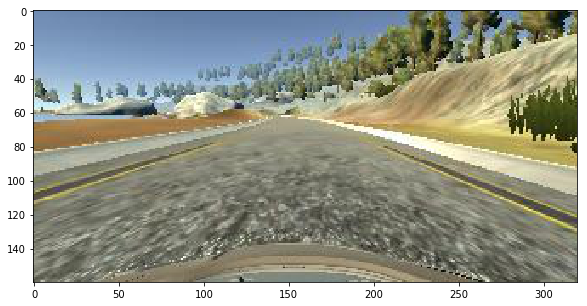

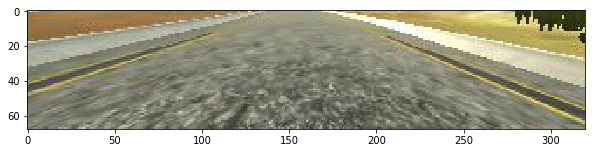

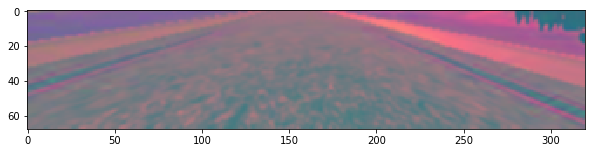

In [10]:
im_index = lines[0][0].find('/images')
image_example = cv2.cvtColor(cv2.imread('..' + lines[0][0][im_index:]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(image_example)
plt.savefig('report_images/original_image.png', bbox_inches='tight')
plt.show()

cropped_img = image_example[65:133,:,:]

plt.figure(figsize=(10,5))
plt.imshow(cropped_img)
plt.savefig('report_images/cropped_image.png', bbox_inches='tight')
plt.show()

b_yuv_img = pre_processing(image_example)

plt.figure(figsize=(10,5))
plt.imshow(b_yuv_img)
plt.savefig('report_images/blurred_yuv_image.png', bbox_inches='tight')
plt.show()

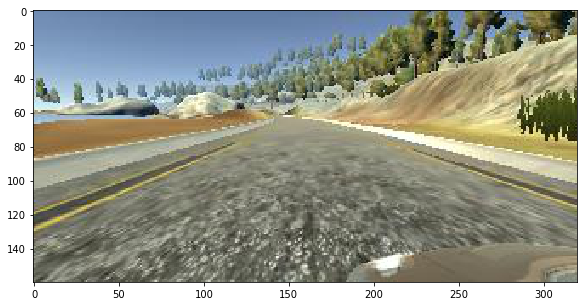

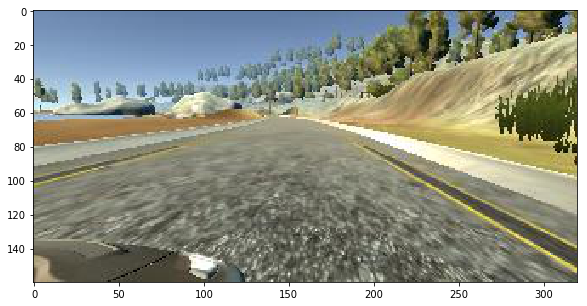

In [12]:
im_index = lines[0][1].find('/images')
image_example_l = cv2.cvtColor(cv2.imread('..' + lines[0][1][im_index:]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(image_example_l)
plt.savefig('report_images/original_image_left.png', bbox_inches='tight')
plt.show()

im_index = lines[0][2].find('/images')
image_example_r = cv2.cvtColor(cv2.imread('..' + lines[0][2][im_index:]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(image_example_r)
plt.savefig('report_images/original_image_right.png', bbox_inches='tight')
plt.show()

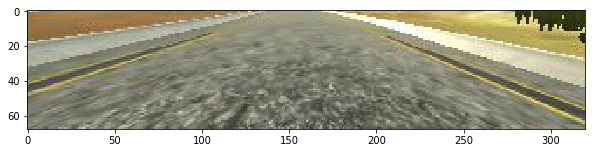

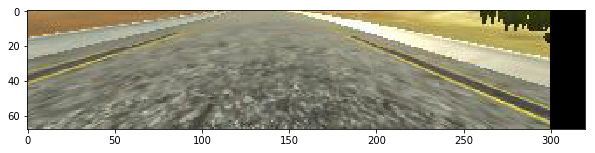

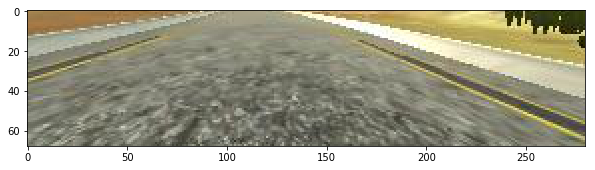

In [55]:
im_index = lines[0][0].find('/images')
image_example = cv2.cvtColor(cv2.imread('..' + lines[0][0][im_index:]), cv2.COLOR_BGR2RGB)
image_example = image_example[65:133, :, :]

plt.figure(figsize=(10,5))
plt.imshow(image_example)
plt.savefig('report_images/original_image_noshift.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(translation(image_example, t=(20,0)))
plt.savefig('report_images/original_image_shift.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(translation(image_example, t=(20,0))[:,20:300,:])
plt.savefig('report_images/original_image_shift_crop.png', bbox_inches='tight')
plt.show()

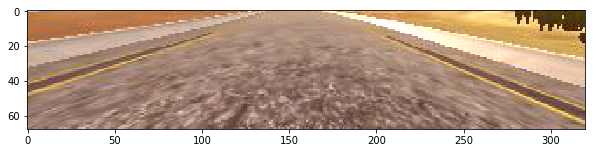

In [57]:
plt.figure(figsize=(10,5))
plt.imshow(augment_brightness(image_example))
plt.savefig('report_images/original_image_bright.png', bbox_inches='tight')
plt.show()

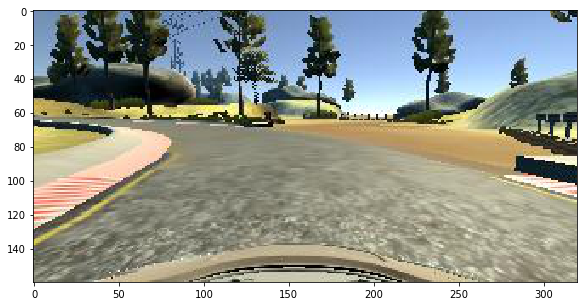

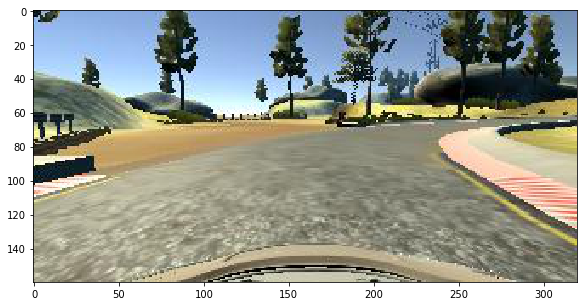

In [24]:
im_index = lines[1050][0].find('/images')
image_example = cv2.cvtColor(cv2.imread('..' + lines[480][0][im_index:]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(image_example)
plt.savefig('report_images/original_image_notflipped.png', bbox_inches='tight')
plt.show()

flipped_image = np.fliplr(image_example)

plt.figure(figsize=(10,5))
plt.imshow(flipped_image)
plt.savefig('report_images/original_image_flipped.png', bbox_inches='tight')
plt.show()

In [ ]:
# Generator to generate images for test of obtained model

def generator_test(samples, batch_size=2048):
    num_samples = len(samples)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            measurements = []
            for sample in batch_samples:
                im_index = sample[0].find('/images')
                
                if im_index < 0:
                    image_c = cv2.imread('../images/RunU/' + str.strip(sample[0]))
                else:
                    image_c = cv2.imread('..' + sample[0][im_index:])
                image_c = pre_processing(image_c)
                angle_c = float(sample[3])
                images.append(image_c)
                measurements.append(angle_c)
                
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield X_train, y_train

In [ ]:
# Ensure model is defined
try:
    model
except NameError:
    model = None

if model is None:
	model = load_model('model.h5')

data_paths_tester = ['../images/Run/']
lines_tester = []
for path in data_paths_tester:
    with open(path + 'driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lines_tester.append(line)
tester = generator_test(lines_tester)

In [ ]:
[imgs, ang] = next(tester)
for img in imgs:
    img = pre_processing(img)
ang_predict = model.predict(imgs)
plt.figure(figsize=(15,5))
plt.plot(ang)
plt.plot(ang_predict)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(imgs[600])
plt.show()